# Домашнее задание №8 по курсу "Машинное обучение"

Прокопенко Тимофей

### Задача 1.
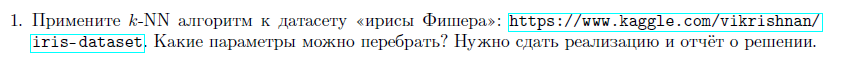

**Решение:**<br>
Для начала нужно загрузить данные и предобработать их. На этом же этапе заменим лейблы класификации на 0-2 для более удобной последующей обработки.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from scipy.spatial import distance
import math
from tqdm import tqdm

In [2]:
def change_labels(iris_df):
    classes = ('Iris-setosa', 'Iris-versicolor', 'Iris-virginica')
    labels_dict = dict(zip(classes, range(len(classes))))
    for key in labels_dict:
        iris_df.loc[(iris_df.type == key), 'type'] = labels_dict[key]


def preprocess_data(path, split_ratio=0.1):
    col = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'type']
    iris_df = pd.read_csv(path, names=col)
    change_labels(iris_df)
    data = iris_df.values
    data[:, :-1] = preprocessing.normalize(data[:, :-1])
    np.random.shuffle(data)
    split_index = int(len(data) * split_ratio)
    return data[split_index:], data[:split_index]

train_data, test_data = preprocess_data('iris.data.csv')

Теперь применим к данному датасету алгоритм k-NN. Основной параметр для перебора - k. Также можно рассмотреть влияние различных метрик расстояния(chi-square, euclidian, cosine) на итоговый результат.

In [3]:
def knn(train_data, test_data, k, distance_metric):
    train_x, train_y = train_data[:, :-1], train_data[:, -1]
    test_x, test_y = test_data[:, :-1], test_data[:, -1]

    pred_y = np.zeros(len(test_y))
    for index_test, test_x_item in enumerate(test_x):
        # calculate distances
        distances_to_train = {}
        for index_train, train_x_item in enumerate(train_x):
            distances_to_train[index_train] = distance_metric(train_x_item, test_x_item)
        # take k closest neighbours
        sorted_distances = sorted(distances_to_train.items(), key=lambda kv: kv[1])
        indices_of_closest = [x[0] for x in sorted_distances[:k]]
        neighbours = train_y[indices_of_closest].astype(int)
        # count max and make an assumption
        pred_y[index_test] = np.bincount(neighbours).argmax()
    
    # compare an assumption with the true labels
    error = 1 - (np.sum(pred_y == test_y) / len(test_y))

    return error

In [4]:
def kfold(train_data, k, metric, n_folds=10):
    np.random.shuffle(train_data)
    parts = np.array_split(train_data, n_folds)
    sum_error = 0.0
    for i in range(n_folds):
        valid_sample = parts[i]
        train_sample = np.concatenate(np.delete(parts, i))
        sum_error += knn(train_sample, valid_sample, k, metric)
    return sum_error / n_folds

In [5]:
def chi_squared(p, q):
    return 0.5*np.sum((p-q)**2/(p+q+1e-6))


def euclidian(p, q):
    return math.sqrt(sum([(a - b) ** 2 for a, b in zip(p, q)]))

def search_parameters(train_data, test_data):
    distances = [chi_squared, euclidian, distance.cosine]
    k_range = range(1, 80)

    distance_dict = dict(zip(distances, ['chi-square', 'euclidian', 'cosine']))
    for dist_metric in distances:
        valid_errors = [kfold(train_data, k, dist_metric) for k in tqdm(k_range)]
        best_k = np.argmin(valid_errors)
        test_errors = [knn(train_data, test_data, k, dist_metric) for k in tqdm(k_range)]

        plt.plot(k_range, valid_errors)
        plt.plot(k_range, test_errors)
        plt.title(distance_dict[dist_metric])
        plt.legend(['validation errors', 'test errors'], loc='upper right')
        plt.show()

        valid_acc = 100 * (1 - valid_errors[best_k])
        test_acc = 100 * (1 - test_errors[best_k])
        result = f"Best result: distance={distance_dict[dist_metric]}, k={best_k + 1}, " \
                 f"CV accuracy = {valid_acc:0.2f}%, test accuracy = {test_acc:0.2f}%"
        print(result)

100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:03<00:00, 20.67it/s]


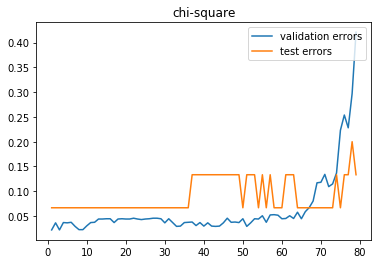

Best result: distance=chi-square, k=3, CV accuracy = 97.80%, test accuracy = 93.33%


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 29.52it/s]


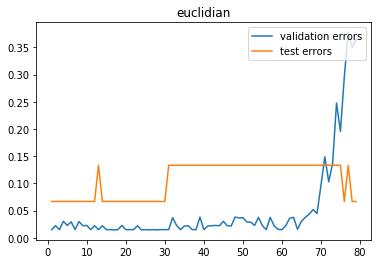

Best result: distance=euclidian, k=24, CV accuracy = 98.57%, test accuracy = 93.33%


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:12<00:00,  6.34it/s]


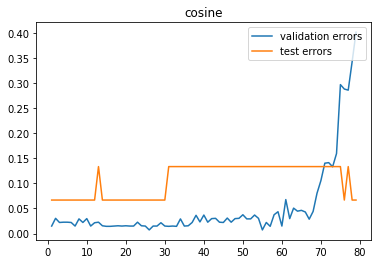

Best result: distance=cosine, k=26, CV accuracy = 99.29%, test accuracy = 93.33%


In [6]:
search_parameters(train_data, test_data)

Таким образом, мы видим что на одних и тех же тестовых и тренировочных данных различные метрики расстояний дают различную точность на кросс-валидации. Значение оптимального параметра k также зависит от выбранной метрики.

Независимо от выбранной метрики точность на тестовой выборке остается такой же.

Стоит также отметить, что данные решения нестабильны в силу малого количества наблюдений в датасете. И различные разделения данных на тест/тренировку сильно влияют на итоговую картину качества модели. В данный отчет включены графики, отображающие наиболее частую ситуацию.